# CONTENTS

### 01) Import Libraries and Data
### 02) Subsetting, Wrangling, and Cleaning Time Series Data
### 03) Decomposition
### 04) Test for Stationarity
### 05) Stationarizing the Data
### 06) Check Autocorrelations

# 01 Import Libraries and Data

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import os
import warnings

warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'REDACTED'

In [3]:
# Importing the Federal Reserve Economic Data 
# "Gross domestic product (GDP); total , Quarterly, Transactions, NSA" variable.

data = quandl.get('FED/FU086902001_Q')

In [4]:
data.head()

,Value
Date,
1946-12-31,227812.0
1947-12-31,249945.0
1948-12-31,274807.0
1949-12-31,272827.0
1950-12-31,300198.0


In [5]:
data.shape

(285, 1)

In [6]:
data.columns

Index(['Value'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

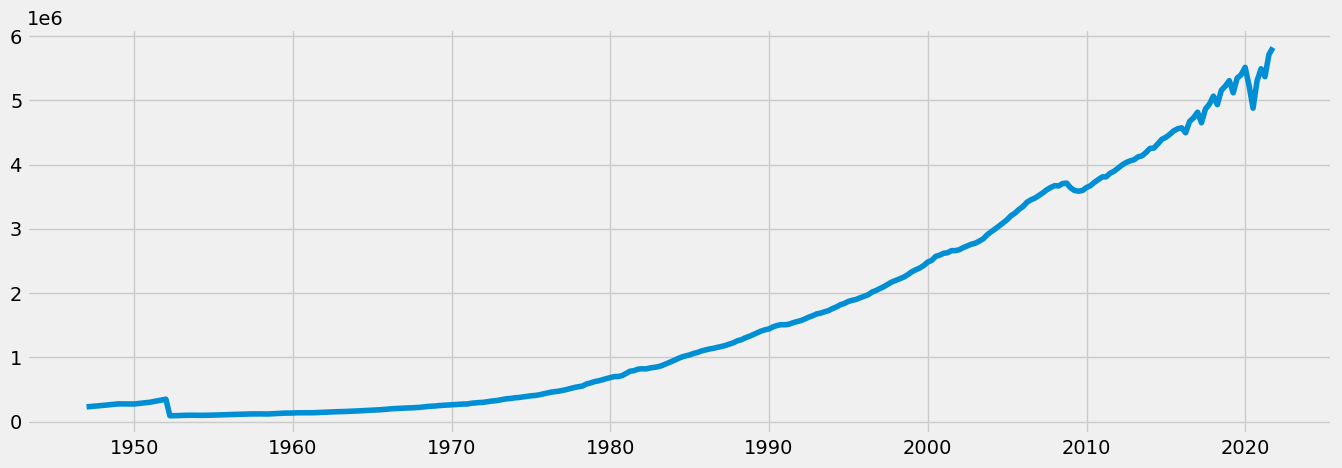

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data)

# 02 Subsetting, Wrangling, and Cleaning Time Series Data

In [10]:
#Set date to column instead of index
data_2 = data.reset_index()

In [12]:
data_2.head()

,Date,Value
0,1946-12-31,227812.0
1,1947-12-31,249945.0
2,1948-12-31,274807.0
3,1949-12-31,272827.0
4,1950-12-31,300198.0


In [19]:
data_2.dtypes

Date     datetime64[ns]
Value           float64
dtype: object

In [20]:
data_2.tail()

,Date,Value
280,2020-09-30,5302337.0
281,2020-12-31,5490052.0
282,2021-03-31,5367754.0
283,2021-06-30,5711844.0
284,2021-09-30,5820866.0


#### There is no forecasted data.

In [22]:
data_2.head(10)

,Date,Value
0,1946-12-31,227812.0
1,1947-12-31,249945.0
2,1948-12-31,274807.0
3,1949-12-31,272827.0
4,1950-12-31,300198.0
5,1951-12-31,347294.0
6,1952-03-31,90049.0
7,1952-06-30,90354.0
8,1952-09-30,92021.0
9,1952-12-31,95310.0


#### 1952 is the first year when data is collected quarterly rather than annually.

In [23]:
#Create subset starting Q1 1975
data_sub = data_2.loc[(data_2['Date'] >= '1975-01-01')]

#### I chose 1975 as the starting point because it is when the GDP is around the same prior to the recession that started in 1953. This is the only significant recession predating 2008, so I thought that it should be ignored.

In [24]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date."
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1975-03-31,404888.0
1975-06-30,414112.0
1975-09-30,428453.0
1975-12-31,441467.0
1976-03-31,456127.0


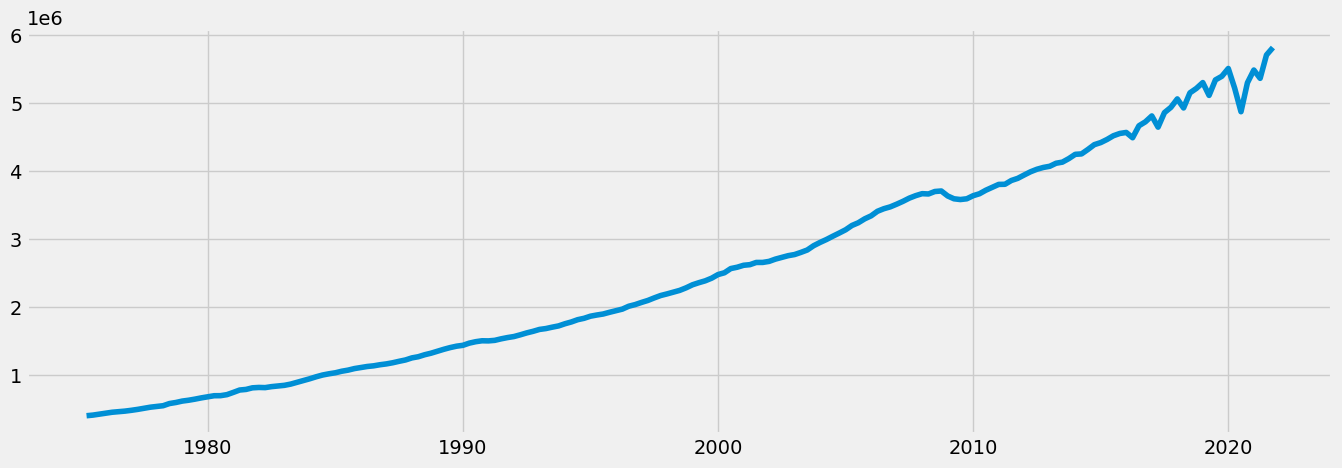

In [25]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [26]:
# Check for missing values

data_sub.isnull().sum() 

Value    0
dtype: int64

In [27]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

0

# 03 Decomposition

In [28]:
# Decompose the time series using an additive model
# because data is near linear

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [29]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

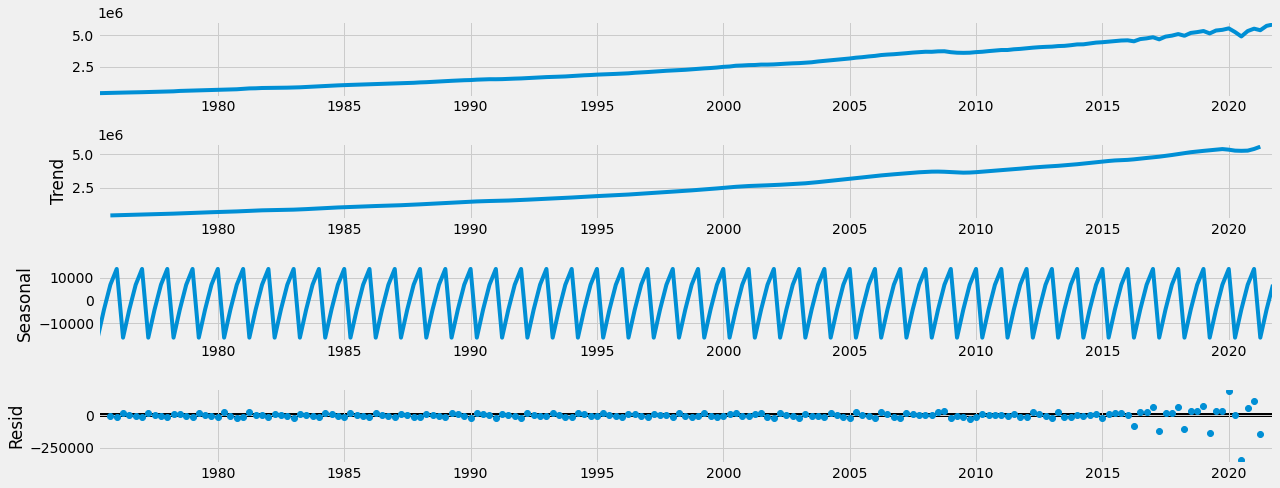

In [30]:
# Plot the separate components

decomposition.plot()
plt.show()

#### The overall trend is increasing. There is seasonality, as the seasonal curve is not flat. The residual curve shows little noise until 2016, where there it is more significant.

# 04 Test for Stationarity

In [31]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. Also need to define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   2.993134
p-value                          1.000000
Number of Lags Used             14.000000
Number of Observations Used    172.000000
Critical Value (1%)             -3.468952
Critical Value (5%)             -2.878495
Critical Value (10%)            -2.575809
dtype: float64


#### H0 is the presence of a unit root in the data (the data is non-stationary), so HA is that there is no unit root (the data is stationary). Because the test statistic is larger than then critical values, we can't reject the null hypothesis. Therefore, there is a unit root and the data is non-stationary.

# 05 Stationarizing the Data

In [32]:
data_diff = data_sub - data_sub.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [33]:
# Remove nulls
data_diff.dropna(inplace = True)

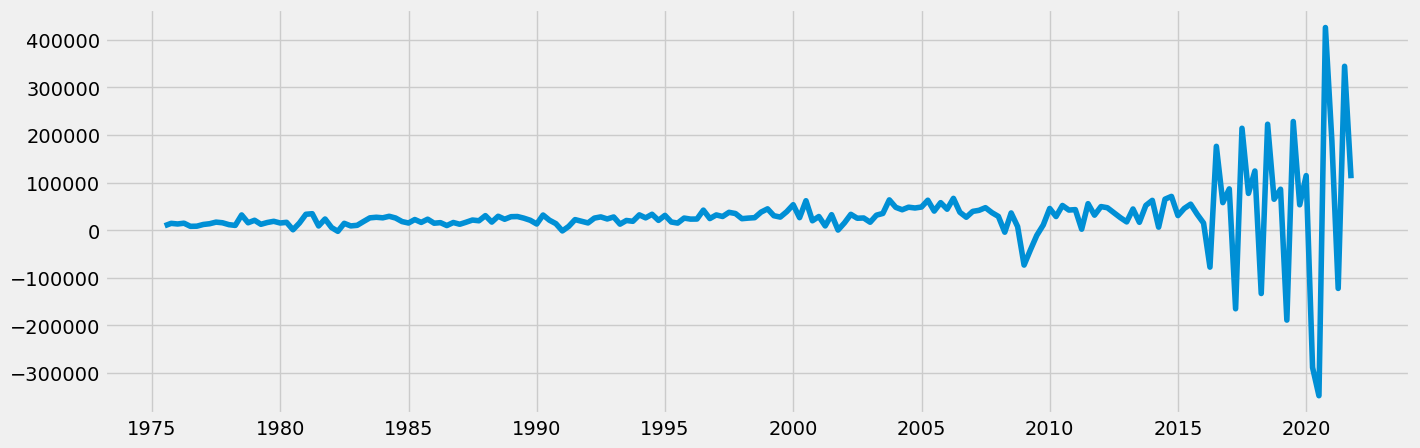

In [34]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [35]:
# Second dicky fuller test
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.371047
p-value                          0.150075
Number of Lags Used             13.000000
Number of Observations Used    172.000000
Critical Value (1%)             -3.468952
Critical Value (5%)             -2.878495
Critical Value (10%)            -2.575809
dtype: float64


#### The test statistic is still larger than the critical values, so the data is still non-stationary.

In [36]:
data_diff_2 = data_diff - data_diff.shift(1)

In [37]:
data_diff_2.dropna(inplace = True)

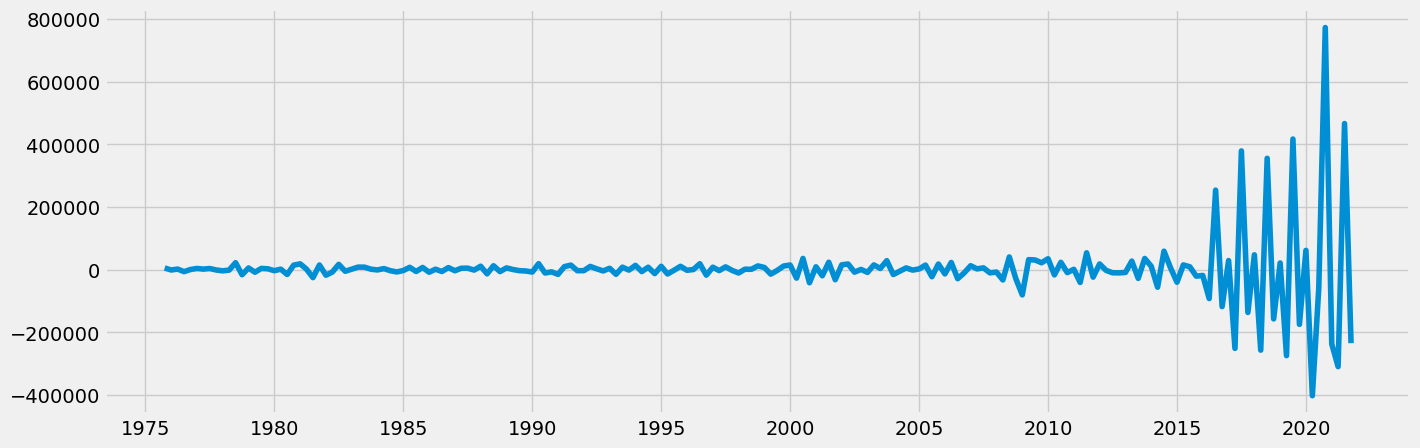

In [38]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff_2)

In [39]:
#Third dickey fuller test
dickey_fuller(data_diff_2)

Dickey-Fuller Stationarity test:
Test Statistic                -6.059047e+00
p-value                        1.225124e-07
Number of Lags Used            1.200000e+01
Number of Observations Used    1.720000e+02
Critical Value (1%)           -3.468952e+00
Critical Value (5%)           -2.878495e+00
Critical Value (10%)          -2.575809e+00
dtype: float64


#### The test statistic is now below the critical values, even including the 1% critical value. Thus, the null hypothesis can be rejected, there is no unit root, and the data is stationary.

# 06 Check Autocorrelations

<function matplotlib.pyplot.show(close=None, block=None)>

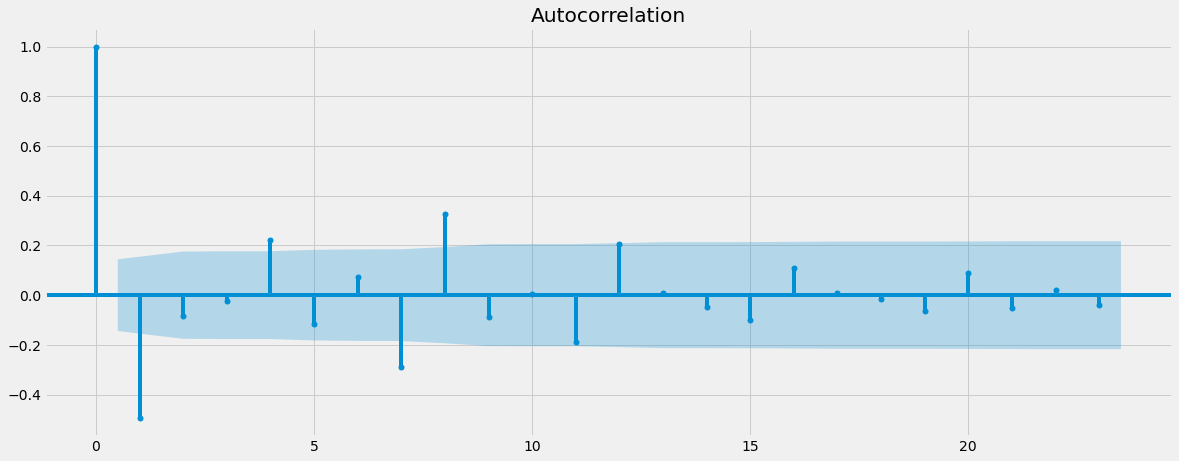

In [41]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_diff_2)
plt.show

#### There are only 5 significant lags, above the confidence interval, so another round of differencing is not necessary.